In [13]:
# import necessary libraries
import os
import cv2
import numpy as np
import re
import nibabel as nib
import scipy.ndimage as ndi
from math import sqrt, exp
from matplotlib import pyplot as plt
!pip install dipy
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
train_path = '/content/drive/MyDrive/Image and Video Processing/Project/Datasets/MSSEG-2016/Training'
test_path = '/content/drive/MyDrive/Image and Video Processing/Project/Datasets/MSSEG-2016/Testing'

In [ ]:
# Extract paths to raw data
T1_path = []
FLAIR_path = []
T2_path = []
GD_path = []
FLAIR_preprocessed = []
GD_preprocessed = []
T1_preprocessed = []
T2_preprocessed = []
mask_path = []
for subdir, dirs, files in os.walk(train_path):
    for file in files:
      if re.fullmatch('FLAIR.nii.gz', file):
        filename = os.path.join(subdir, file)
        FLAIR_path.append(filename)
      if re.fullmatch('T2.nii.gz', file):
        filename = os.path.join(subdir, file)
        T2_path.append(filename)
      if re.fullmatch('T1.nii.gz', file):
        filename = os.path.join(subdir, file)
        T1_path.append(filename)
      if re.fullmatch('GADO.nii.gz', file):
        filename = os.path.join(subdir, file)
        GD_path.append(filename)
      if re.fullmatch('FLAIR_preprocessed.nii.gz', file):
        filename = os.path.join(subdir, file)
        FLAIR_preprocessed.append(filename)
      if re.fullmatch('T2_preprocessed.nii.gz', file):
        filename = os.path.join(subdir, file)
        T2_preprocessed.append(filename)
      if re.fullmatch('T1_preprocessed.nii.gz', file):
        filename = os.path.join(subdir, file)
        T1_preprocessed.append(filename)
      if re.fullmatch('GADO_preprocessed.nii.gz', file):
        filename = os.path.join(subdir, file)
        GD_preprocessed.append(filename)
      if re.fullmatch('Consensus.nii.gz', file):
        filename = os.path.join(subdir, file)
        mask_path.append(filename)

In [ ]:
# take 1st raw data as sample (extract cross-sections to show)
FLAIR_samp = nib.load(FLAIR_path[0]).dataobj[..., 130:220]
T1_samp = nib.load(T1_path[0]).dataobj[..., 55:-1]
T2_samp = nib.load(T2_path[0]).dataobj[..., 0:-1]
GD_samp = nib.load(GD_path[0]).dataobj[..., 55:-1]
FLAIR_pre = nib.load(FLAIR_preprocessed[0]).dataobj[..., 130:220]
T1_pre = nib.load(T1_preprocessed[0]).dataobj[..., 130:220]
T2_pre = nib.load(T2_preprocessed[0]).dataobj[..., 130:220]
GD_pre = nib.load(GD_preprocessed[0]).dataobj[..., 130:220]
masks = nib.load(mask_path[0]).dataobj[..., 130:220]

In [ ]:
FLAIR_samp = np.delete(FLAIR_samp, slice(0, 20), 1)
FLAIR_samp = cv2.resize(FLAIR_samp, (256,192))
FLAIR_samp = np.pad(FLAIR_samp, ((32,32),(0,0),(0,0)), 'constant')

FLAIR_pre = np.delete(FLAIR_pre, slice(0, 20), 1)
FLAIR_pre = cv2.resize(FLAIR_pre, (256,192))
FLAIR_pre = np.pad(FLAIR_pre, ((32,32),(0,0),(0,0)), 'constant')

T1_pre = np.delete(T1_pre, slice(0, 20), 1)
T1_pre = cv2.resize(T1_pre, (256,192))
T1_pre = np.pad(T1_pre, ((32,32),(0,0),(0,0)), 'constant')

T2_pre = np.delete(T2_pre, slice(0, 20), 1)
T2_pre = cv2.resize(T2_pre, (256,192))
T2_pre = np.pad(T2_pre, ((32,32),(0,0),(0,0)), 'constant')

GD_pre = np.delete(GD_pre, slice(0, 20), 1)
GD_pre = cv2.resize(GD_pre, (256,192))
GD_pre = np.pad(GD_pre, ((32,32),(0,0),(0,0)), 'constant')

masks = np.delete(masks, slice(0, 20), 1)
masks = cv2.resize(masks, (256,192))
masks = np.pad(masks, ((32,32),(0,0),(0,0)), 'constant')

In [ ]:
print(FLAIR_samp.shape)
print(T1_samp.shape)
print(T2_samp.shape)
print(GD_samp.shape)
print(FLAIR_pre.shape)
print(T1_pre.shape)
print(T2_pre.shape)
print(GD_pre.shape)

(256, 256, 90)
(256, 256, 120)
(320, 320, 24)
(256, 256, 120)
(256, 256, 90)
(256, 256, 90)
(256, 256, 90)
(256, 256, 90)


In [ ]:
def PSNR(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX /np.sqrt(mse))

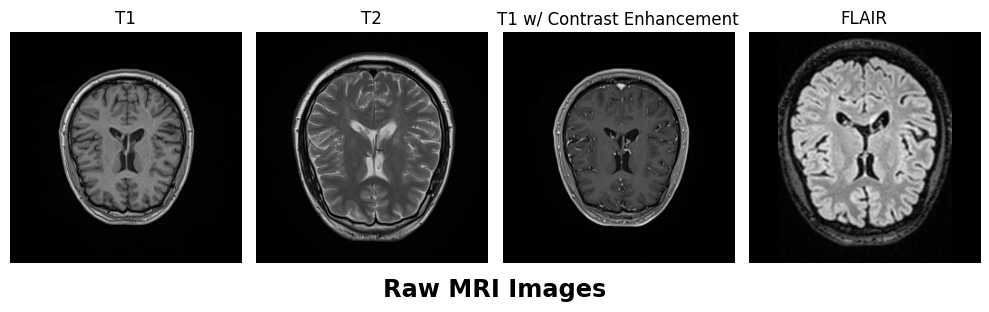

In [ ]:
# Display Each MRI type (raw)
fig_rows = 1
fig_cols = 4

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])

fig.suptitle('Raw MRI Images', y=0.2, weight='bold', size='xx-large')
axs.flat[0].set_title('T1')
axs.flat[0].imshow(ndi.rotate(T1_samp[:, :, 45], 90), cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].set_title('T2')
axs.flat[1].imshow(ndi.rotate(T2_samp[:, :, 15], 90), cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].set_title('T1 w/ Contrast Enhancement')
axs.flat[2].imshow(ndi.rotate(GD_samp[:, :, 45], 90), cmap='gray')
axs.flat[2].axis('off')
axs.flat[3].set_title('FLAIR')
axs.flat[3].imshow(ndi.rotate(FLAIR_samp[:, :, 34], 90), cmap='gray')
axs.flat[3].axis('off')
        
plt.tight_layout()
plt.show()

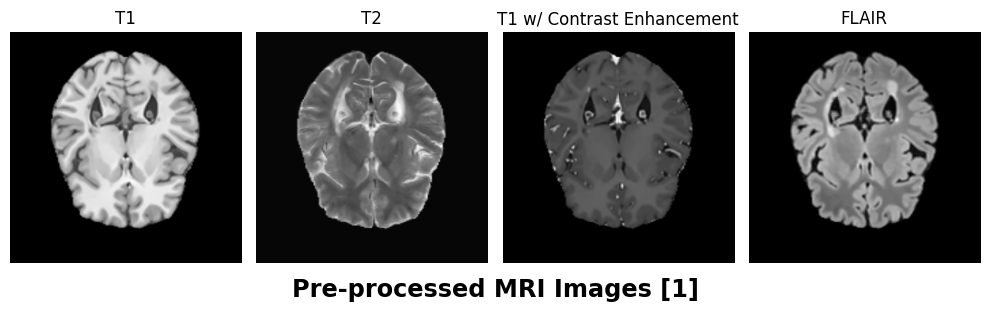

In [ ]:
# Display Each MRI type (preprocessed by [1])
fig_rows = 1
fig_cols = 4

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])

fig.suptitle('Pre-processed MRI Images [1]', y=0.2, weight='bold', size='xx-large')
axs.flat[0].set_title('T1')
axs.flat[0].imshow(ndi.rotate(T1_pre[:, :, 25], 90), cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].set_title('T2')
axs.flat[1].imshow(ndi.rotate(T2_pre[:, :, 25], 90), cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].set_title('T1 w/ Contrast Enhancement')
axs.flat[2].imshow(ndi.rotate(GD_pre[:, :, 25], 90), cmap='gray')
axs.flat[2].axis('off')
axs.flat[3].set_title('FLAIR')
axs.flat[3].imshow(ndi.rotate(FLAIR_pre[:, :, 25], 90), cmap='gray')
axs.flat[3].axis('off')
        
plt.tight_layout()
plt.show()

In [18]:
# Anisotropic Diffusion Filtering
def adf(samp, n_iter, kappa, gamma):
  # kappa is the diffusivity parameter
  # gamma represents the learning rate of the gradient update (time-step)

  # Convert the input to float
  img = np.float32(samp)

  # Container for diffusion
  diffused_img = img.copy()

  # Loop over the number of iterations
  for i in range(n_iter):

      # compute the gradient along each dimension
      gradient = np.gradient(diffused_img)
      dx = gradient[0]
      dy = gradient[1]
      dz = gradient[2]
      
      # Compute the magnitude of the gradients
      magnitude = np.sqrt(dx**2 + dy**2 + dz**2)

      # compute the conduction coefficients
      c = np.exp(-(magnitude/ kappa)**2)

      # compute the divergence
      dxx, dxy, dxz = np.gradient(c*dx)
      dyx, dyy, dyz = np.gradient(c*dy)
      dzx, dyz, dzz = np.gradient(c*dz)
      div = dxx + dyy + dzz

      # Update the diffused_img using the gradients
      diffused_img += gamma*div


  # Convert the image back to uint16 and return it
  diffused_img = np.interp(diffused_img, (diffused_img.min(), diffused_img.max()), (0, 1))
  diffused_img = np.uint16(diffused_img * 255)

  return diffused_img


def nlm2(samp, alpha, M, h):
  # Convert the input to float
  img = np.float64(samp)

  # block_size
  block_sz = 2*alpha + 1
  Ni = block_sz**3

  # block distance
  n = 2*alpha

  # search_size
  search_sz = 2*M + 1

  # sample size
  Nx, Ny, Nz = img.shape

  # create containers for values
  means = np.zeros(img.shape)
  vars = np.zeros(img.shape)
  estimate = np.zeros(img.shape)
  values = np.zeros(img.shape)
  blocks = np.zeros((block_sz, block_sz, block_sz), dtype=np.float64)
  denoised = np.zeros(img.shape)

  # comparison parameters
  epsilon = 1e-6
  mu1 = 0.95
  var1 = 0.5 + epsilon

  # function to calculate the local mean around a voxel
  def local_mean(img, vox):
    sum = 0
    x = vox[0]
    y = vox[1]
    z = vox[2]
    for i in range(x-1,x+2):
      for j in range(y-1,y+2):
        for k in range(z-1,z+2):
          # check for edges
          i = -i if i<0 else 2*Nx-i-1 if i>=Nx else i
          j = -j if j<0 else 2*Ny-j-1 if j>=Ny else j
          k = -k if k<0 else 2*Nz-k-1 if k>=Nz else k
          # calculate cumulative sum
          sum += img[i,j,k]
    # compute mean
    mean = sum/27.0
    return mean

  # function to calculate local variance around voxel
  def local_var(img, mean, vox):
    x = vox[0]
    y = vox[1]
    z = vox[2]
    var = 0
    ct = 0
    for i in range(x-1,x+2):
      for j in range(y-1,y+2):
        for k in range(z-1,z+2):
          # only compute variance for points within borders
          if (i>=0 and j>=0 and k>=0) and (i<Nx and j<Ny and k<Nz):
            var += (img[i,j,k]-mean)**2
            ct += 1
    # normalize
    var = var/(ct-1)
    return var

  # function to compute the weighted blocks
  def block_weighted(img, weights, blocks, vox):
    x = vox[0]
    y = vox[1]
    z = vox[2]
    for i in range(block_sz):
      for j in range(block_sz):
        for k in range(block_sz):
          x_pos = x + i - block_sz
          y_pos = y + j - block_sz
          z_pos = z + k - block_sz
          # check if within borders
          if (x_pos>=0 and y_pos>=0 and z_pos>=0) and (x_pos<Nx and y_pos<Ny and z_pos<Nz):
            blocks[i,j,k] += weights*img[x_pos,y_pos,z_pos]**2
          else:
            blocks[i,j,k] += weights*img[x,y,z]**2
    return blocks

  # function to compute distances between two blocks
  def distance(image, vox1, vox2):
    ct = 0
    total_dist = 0
    # center voxel
    xi = vox1[0]
    yi = vox1[1]
    zi = vox1[2]
    # neighbour voxel
    xn = vox2[0]
    yn = vox2[1]
    zn = vox2[2]
    for i in range(-alpha, alpha+1):
      for j in range(-alpha, alpha+1):
        for k in range(-alpha, alpha+1):
          x1 = xi+ i
          y1 = yi + j
          z1 = zi + k
          x2 = xn + i
          y2 = yn + j
          z2 = zn + k
          x1 = -x1 if x1<0 else 2*Nx-x1-1 if x1>=Nx else x1
          y1 = -y1 if y1<0 else 2*Ny-y1-1 if y1>=Ny else y1
          z1 = -z1 if z1<0 else 2*Nz-z1-1 if z1>=Nz else z1
          x2 = -x2 if x2<0 else 2*Nx-x2-1 if x2>=Nx else x2
          y2 = -y2 if y2<0 else 2*Ny-y2-1 if y2>=Ny else y2
          z2 = -z2 if z2<0 else 2*Nz-z2-1 if z2>=Nz else z2
          total_dist += (img[x1,y1,z1]-img[x2,y2,z2])**2
          ct += 1
    dist = total_dist/ct
    return dist

  # function to compute the denoised image values
  def block_values(estimate, Label, blocks, cum_sum, vox):
    x = vox[0]
    y = vox[1]
    z = vox[2]
    value = 0.0
    denoised_val = 0.0
    label = 0.0
    for i in range(block_sz):
      for j in range(block_sz):
        for k in range(block_sz):
          x_pos = x + i - block_sz
          y_pos = y + j - block_sz
          z_pos = z + k - block_sz
          # check if within borders
          if (x_pos>=0 and y_pos>=0 and z_pos>=0) and (x_pos<Nx and y_pos<Ny and z_pos<Nz):
            value = estimate[x_pos,y_pos,z_pos]
            denoised_val = blocks[i,j,k]/cum_sum
            if denoised_val>0:
              denoised_val = sqrt(denoised_val)
            else:
              denoised_val = 0
            value += denoised_val
            label = Label[x_pos,y_pos,z_pos]
            estimate[x_pos,y_pos,z_pos] = value
            Label[x_pos,y_pos,z_pos] = label+1
    return Label, estimate

  # compute initial mean and variance of all voxels
  for vox in np.ndindex(Nx, Ny, Nz):
    i = vox[0]
    j = vox[1]
    k = vox[2]
    means[i,j,k] = local_mean(img, vox)
    vars[i,j,k] = local_var(img, means[i,j,k], vox)

  # loop through voxels by block distances
  for i in range(0, Nx, n):
    for j in range(0, Ny, n):
      for k in range(0, Nz, n):
        cum_sum = 0.0
        blocks = np.zeros((block_sz, block_sz, block_sz), dtype=np.float64)
        # check if block is mostly dark or monotone
        if (means[i,j,k] <= epsilon) or (vars[i,j,k] <= epsilon):
          wmax = 1.0
          blocks = block_weighted(img, wmax, blocks, [i,j,k])
          cum_sum += wmax
          values, estimate = block_values(estimate, values, blocks, cum_sum, [i,j,k])
        else:
          wmax = 0.0
          # loop through search window
          for ni in range(i-M, i+M+1):
            for nj in range(j-M, j+M+1):
              for nk in range(k-M, k+M+1):
                # skip if is the current vox
                if ni == i and nj == j and nk == k:
                  continue
                # skip if not within borders
                if ni<0 or nj<0 or nk<0 or ni>=Nx or nj>=Ny or nk>=Nz:
                  continue
                # compute similarities between main vox block and neighbor blocks
                mu = means[i,j,k]/means[ni,nj,nk]
                sigma = vars[i,j,k]/vars[ni,nj,nk]
                if mu1<mu<(1/mu1) and var1<sigma<(1/var1):
                  dist = distance(img, [i,j,k], [ni,nj,nk])
                  w = exp(-dist/h**2)
                  if w > wmax:
                    wmax = w
                    blocks = block_weighted(img, wmax, blocks, [ni,nj,nk])
                    cum_sum += w
          if cum_sum != 0.0:
            values, estimate = block_values(estimate, values, blocks, cum_sum, [i,j,k])

  # update denoised image values
  for vox in np.ndindex(Nx, Ny, Nz):
    i = vox[0]
    j = vox[1]
    k = vox[2]
    if values[i,j,k] == 0:
      denoised[i,j,k] = img[i,j,k]
    else:
      denoised[i,j,k] = estimate[i,j,k]/values[i,j,k]

  return denoised


In [19]:
FLAIR_nlm2 = nlm2(FLAIR_samp, 1, 1, 4)

<ipython-input-18-81cf10ec4ca8>:304: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = vars[i,j,k]/vars[ni,nj,nk]
<ipython-input-18-81cf10ec4ca8>:303: RuntimeWarning: divide by zero encountered in double_scalars
  mu = means[i,j,k]/means[ni,nj,nk]


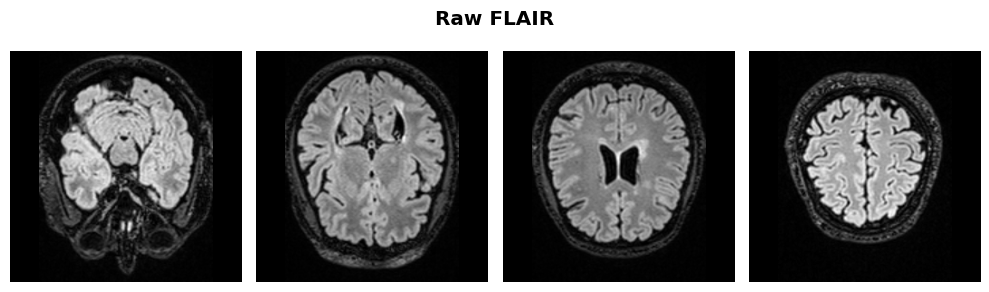

In [22]:
# Display FLAIR raw sample
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = FLAIR_samp.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('Raw FLAIR', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(FLAIR_samp[:, :, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

In [ ]:
sigma = estimate_sigma(FLAIR_samp, N=32)
FLAIR_nlm = nlmeans(FLAIR_samp, sigma=sigma, patch_radius = 1, block_radius = 5, rician=True)

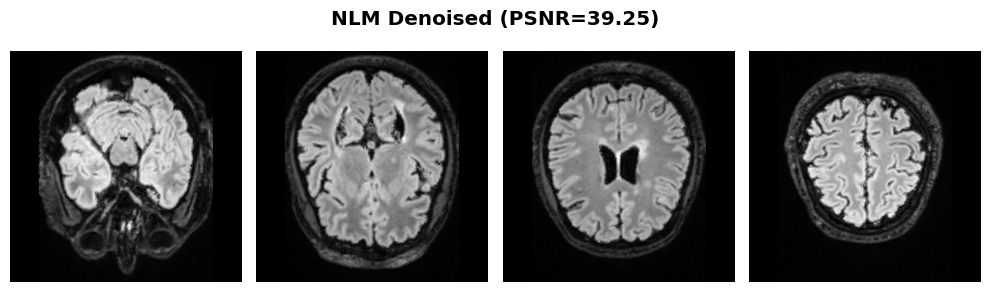

32.82101215834936


In [23]:
# Display FLAIR denoised using NLM
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = FLAIR_nlm.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('NLM Denoised (PSNR=39.25)', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(FLAIR_nlm2[:, :, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

psnr = PSNR(FLAIR_samp, FLAIR_nlm)
print(psnr)

(-0.5, 175.5, 175.5, -0.5)

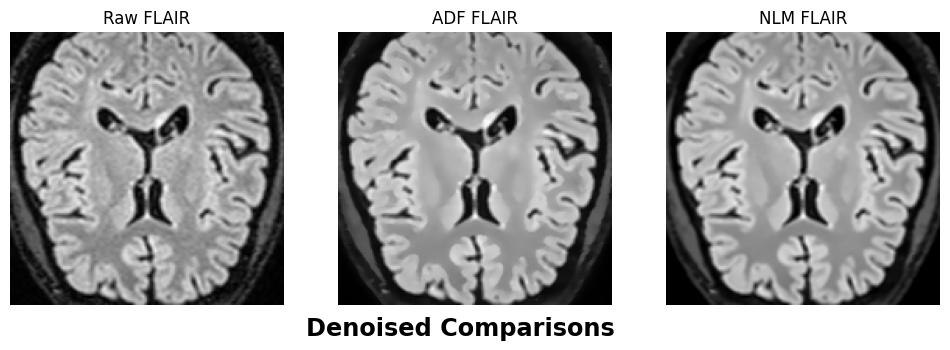

In [ ]:
fig_rows = 1
fig_cols = 3

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[12, 5])

fig.suptitle('Denoised Comparisons', y=0.2, weight='bold', size='xx-large')
axs.flat[0].set_title('Raw FLAIR')
axs.flat[0].imshow(ndi.rotate(FLAIR_samp[40:-40, 40:-40, 34], 90), cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].set_title('ADF FLAIR')
axs.flat[1].imshow(ndi.rotate(FLAIR_adf[40:-40, 40:-40, 34], 90), cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].set_title('NLM FLAIR')
axs.flat[2].imshow(ndi.rotate(FLAIR_nlm[40:-40, 40:-40, 34], 90), cmap='gray')
axs.flat[2].axis('off')

In [ ]:
FLAIR_adf = adf(FLAIR_samp, 10, 10, 0.2)

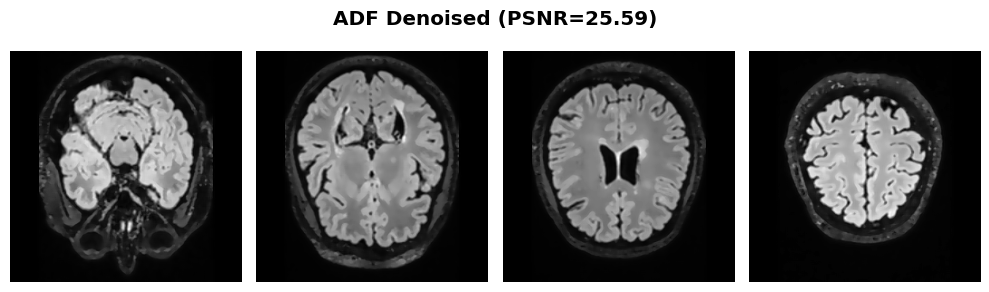

25.585729901569437


In [ ]:
# Display FLAIR denoised using ADF
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = FLAIR_adf.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('ADF Denoised (PSNR=25.59)', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(FLAIR_adf[:, :, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

psnr = PSNR(FLAIR_samp, FLAIR_adf)
print(psnr)

In [ ]:
mask = nib.load('mask.nii').dataobj[..., 55:-1]

In [ ]:
print(mask.shape)

(256, 256, 120)


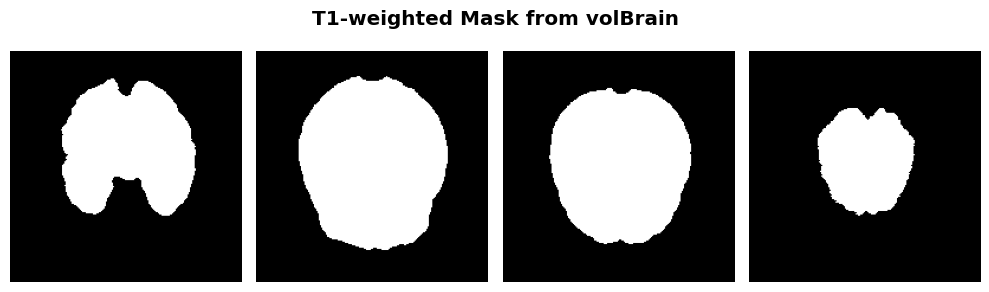

In [ ]:
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = mask.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('T1-weighted Mask from volBrain', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(mask[30:-30, 30:-30, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
T1_adf = adf(T1_samp, 10, 10, 0.2)
masked_T1 = T1_adf.copy()
masked_T1 = mask*masked_T1

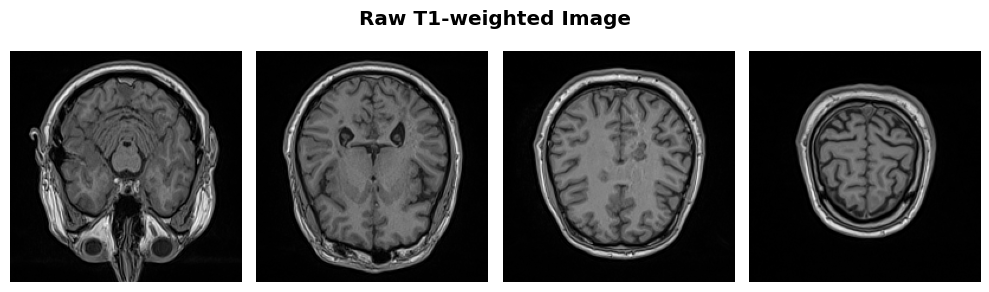

In [ ]:
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = T1_samp.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('Raw T1-weighted Image', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(T1_samp[30:-30, 30:-30, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

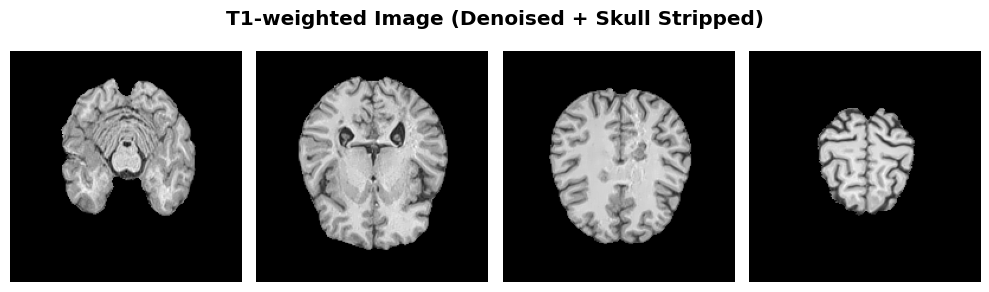

In [ ]:
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = masked_T1.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('T1-weighted Image (Denoised + Skull Stripped)', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(masked_T1[30:-30, 30:-30, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
mask_rsz = mask[30:-30, 30:-30, 15:-15]
mask_rsz = cv2.resize(mask_rsz, (256,256))
mask_rsz.shape

(256, 256, 90)

In [ ]:
masked_FLAIR = FLAIR_adf.copy()
masked_FLAIR = masked_FLAIR*mask_rsz

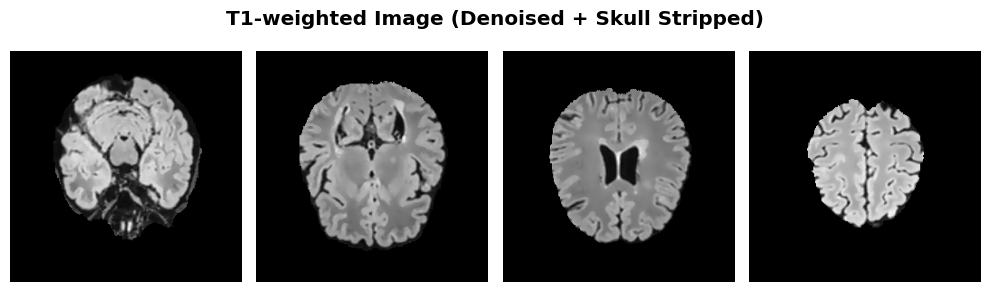

In [ ]:
fig_rows = 1
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = masked_FLAIR.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])
fig.suptitle('T1-weighted Image (Denoised + Skull Stripped)', weight='bold', size='x-large', y=0.78)
for idx, sec in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(masked_FLAIR[:, :, sec], 90), cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()

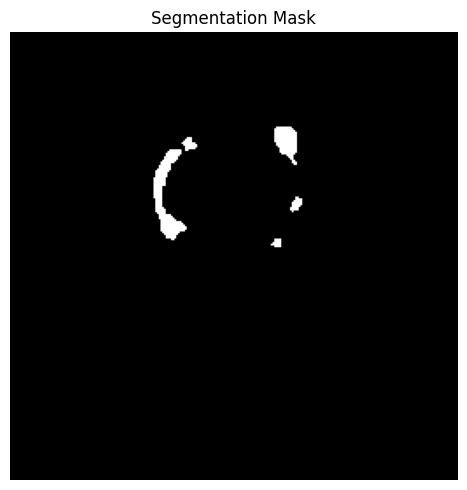

In [ ]:
# mask

fig_rows = 1
fig_cols = 1

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])

axs.set_title('Segmentation Mask')
axs.imshow(ndi.rotate(masks[:, :, 25], 90), cmap='gray')
axs.axis('off')

        
plt.tight_layout()
plt.show()